In [59]:
import sqlite3
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
import spacy

In [46]:
# Create connection to SQLite Database:
conn = sqlite3.connect('../twitoff/twitoff.db')

In [47]:
def get_data(query, conn):
    '''Function to get data from SQLite DB'''
    
    cursor = conn.cursor()
    result = cursor.execute(query).fetchall()
    
    #   Get columns from cursor object
    columns = list(map(lambda x: x[0], cursor.description))
    
    #   Assign to a DataFrame
    df = pd.DataFrame(data=result, columns=columns)
    return df

In [48]:
sql = '''
SELECT
        tweet.id,
        tweet.tweet,
        tweet.embedding,
        user.username
FROM tweet
JOIN user ON tweet.user_id = user.id;
'''

df = get_data(sql, conn)
df['embedding_decoded'] = df.embedding.apply(lambda x: pickle.loads(x))
print(df.shape)
display(df.head)

(768, 5)


<bound method NDFrame.head of                       id                                              tweet  \
0     941805289359081474  Over the last fifteen years, automatic paper t...   
1     942546534478032896  My favorite Christmas song is whatever plays i...   
2     942979592486309889  (SPOILER ALERT) In 100 years, nobody will reme...   
3     943144310651916288  Not true, Little Drummer Boy. You could have g...   
4     943559086511214592  On Christmas morning, Donald Trump waking up a...   
..                   ...                                                ...   
763  1313653514783141889  So I had to constantly fight off all of this S...   
764  1313654133153583104  Wear your mask in the “beauty” parlor, Nancy! ...   
765  1313658825040371712  The House &amp; Senate should IMMEDIATELY Appr...   
766  1313661368856457217  11,00 North Carolina residents get incorrect v...   
767  1313664886648582144  If I am sent a Stand Alone Bill for Stimulus C...   

                     

In [49]:
df.username.value_counts()

badbanana          186
mental_floss       181
SteveMartinToGo    162
johnbcrist         101
pourmecoffee        97
elonmusk            20
realDonaldTrump     12
dustinstri92         9
Name: username, dtype: int64

In [54]:
user1_emb = df.embedding_decoded[df.username == 'badbanana']
user2_emb = df.embedding_decoded[df.username == 'mental_floss']

embeddings = pd.concat([user1_emb, user2_emb])

embeddings_df = pd.DataFrame(embeddings.to_list(),
                            columns=[f'dom{i}' for i in range(300)])
labels = np.concatenate([np.ones(len(user1_emb)),
                        np.zeros(len(user2_emb))])

print(embeddings_df.shape, labels.shape)

(367, 300) (367,)


In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_df, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

(293, 300) (74, 300)


In [56]:
log_reg = LogisticRegression(max_iter=1000)
%timeit log_reg.fit(X_train, y_train)

33.4 ms ± 4.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80        36
         1.0       0.80      0.84      0.82        38

    accuracy                           0.81        74
   macro avg       0.81      0.81      0.81        74
weighted avg       0.81      0.81      0.81        74



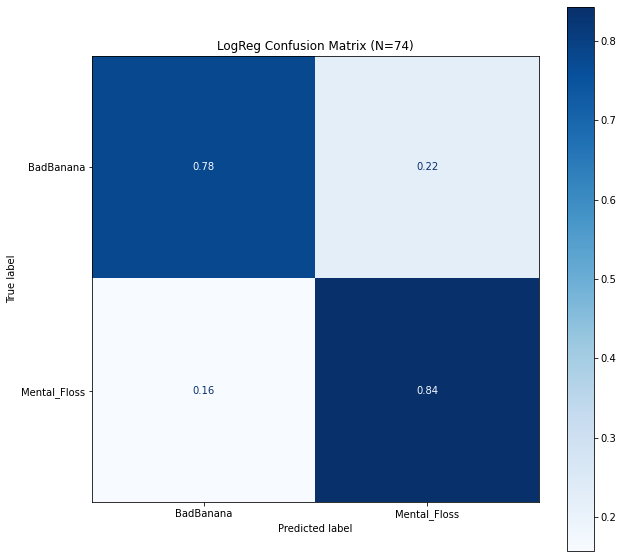

In [58]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(log_reg, X_test, y_test,
                     normalize='true', cmap='Blues',
                     display_labels=['BadBanana', 'Mental_Floss'], ax=ax)
plt.title(f'LogReg Confusion Matrix (N={X_test.shape[0]})');

In [60]:
nlp = spacy.load('en_core_web_md', disable=['tagger', 'parser'])

def vectorize_tweet(nlp, tweet_text):
    '''Returns spacy embeddings for passed in text'''
    return list(nlp(tweet_text).vector)

In [63]:
new_emb = vectorize_tweet(nlp, '''For the final segment tonight, 
                                you'll each have two minutes to throw 
                                feces at each other.''')
new_emb[0:5]

[0.005814955, 0.12815481, -0.12538919, 0.012888247, 0.09633119]

In [64]:
log_reg.predict([new_emb])

array([1.])

In [69]:
pickle.dump(log_reg, open("../models/log_reg.pkl", "wb"))

In [71]:
unpickled_lr = pickle.load(open('../models/log_reg.pkl', 'rb'))
unpickled_lr.predict([new_emb])

array([1.])